In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('cs-training.csv', index_col = 0)
df.head()
df.info()
df.isnull().sum()
df['SeriousDlqin2yrs'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtypes: fl

SeriousDlqin2yrs
0    139974
1     10026
Name: count, dtype: int64

In [3]:
df['MonthlyIncome'] = df['MonthlyIncome'].fillna(df['MonthlyIncome'].median())
df['NumberOfDependents'] = df['NumberOfDependents'].fillna(df['NumberOfDependents'].median())

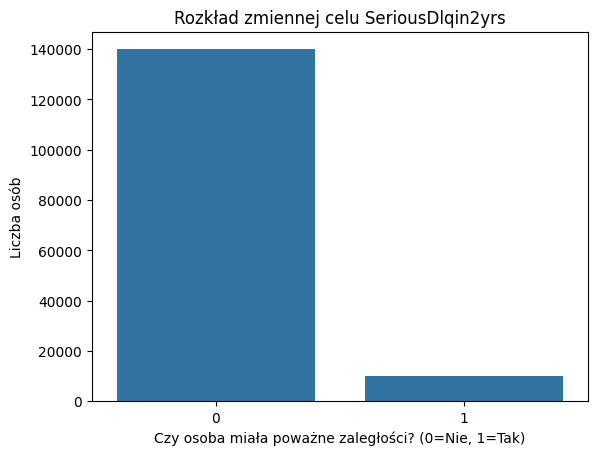

In [4]:
df['SeriousDlqin2yrs'].value_counts()
sns.countplot(x='SeriousDlqin2yrs', data=df)
plt.title('Distribution of the target variable SeriousDlqin2yrs')
plt.xlabel('Did the person had troubles with payments? (0=No, 1=Yes)')
plt.ylabel('Number of people')
plt.show()

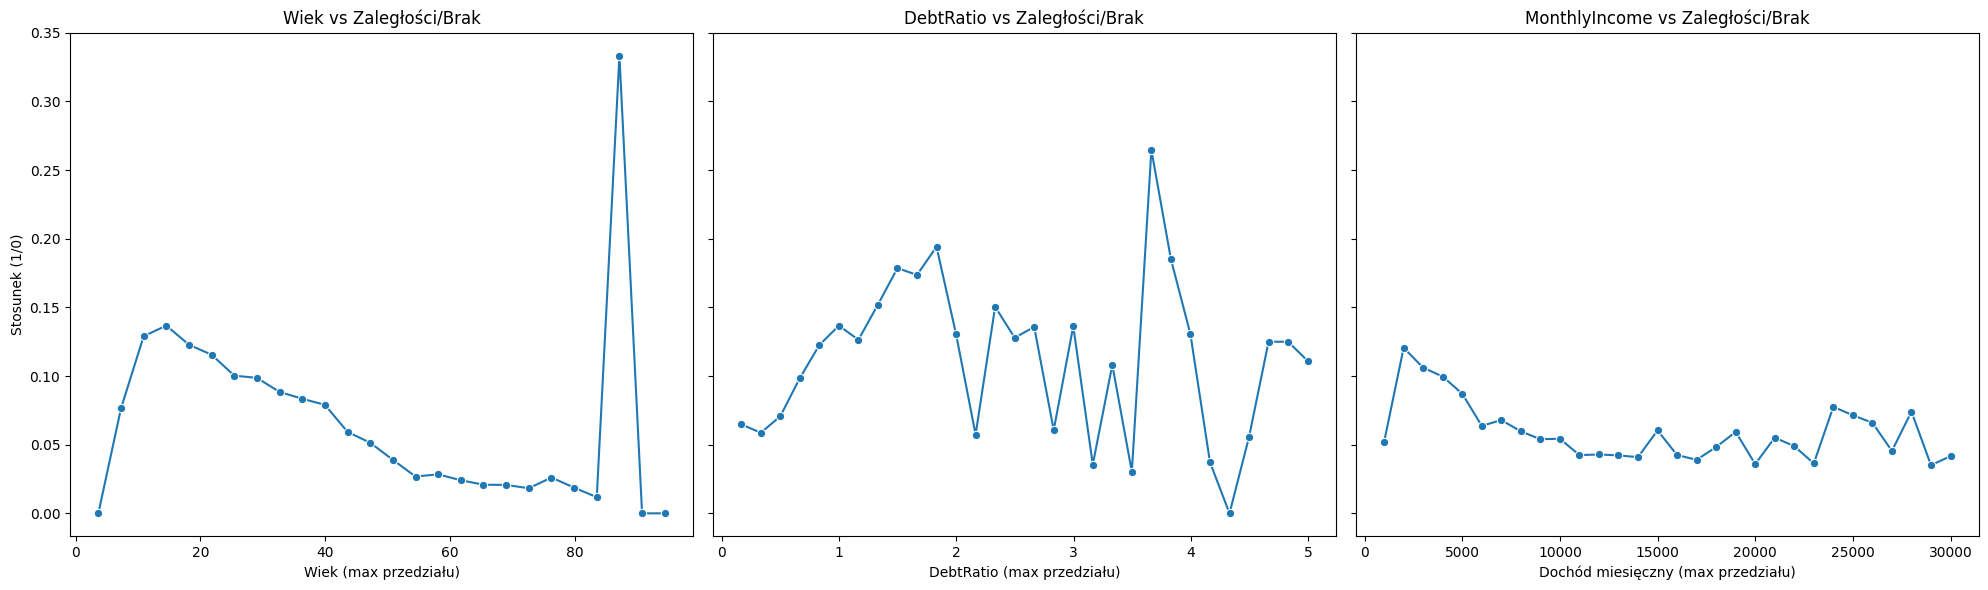

In [5]:
def get_ratio_data(feature, max_val=None, bins=30):
    data = df.copy()
    if max_val is not None:
        data = data[data[feature] < max_val]

    bins_edges = np.linspace(data[feature].min(), data[feature].max(), bins + 1)
    data[f'{feature}_bin'] = pd.cut(data[feature], bins=bins_edges, include_lowest=True)

    grouped = data.groupby([f'{feature}_bin', 'SeriousDlqin2yrs'], observed=True).size().unstack(fill_value=0)

    grouped['ratio'] = grouped.get(1, 0) / grouped.get(0, 1).replace(0, np.nan)
    grouped = grouped.dropna(subset=['ratio'])

    bin_right_edges = bins_edges[1:len(grouped)+1]

    return bin_right_edges, grouped['ratio']

age_x, age_y = get_ratio_data('age')
debt_x, debt_y = get_ratio_data('DebtRatio', max_val=5)
income_x, income_y = get_ratio_data('MonthlyIncome', max_val=30000)

fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

sns.lineplot(x=age_x, y=age_y, marker='o', ax=axes[0])
axes[0].set_title('Age vs Debt/lack of')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Ratio (1/0)')

sns.lineplot(x=debt_x, y=debt_y, marker='o', ax=axes[1])
axes[1].set_title('DebtRatio vs Debt/lack of')
axes[1].set_xlabel('DebtRatio')

sns.lineplot(x=income_x, y=income_y, marker='o', ax=axes[2])
axes[2].set_title('MonthlyIncome vs Debt/lack of')
axes[2].set_xlabel('MonthlyIncome')

plt.tight_layout()
plt.show()

In [6]:
X = df.drop('SeriousDlqin2yrs', axis=1)
y = df['SeriousDlqin2yrs']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

Rozmiar zbioru treningowego: (105000, 10)
Rozmiar zbioru testowego: (45000, 10)


In [7]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
model = LogisticRegression(max_iter=5000, solver='saga', class_weight='balanced', random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]
print(classification_report(y_test, y_pred))

<function classification_report at 0x0000018907DC8700>
              precision    recall  f1-score   support

           0       0.97      0.78      0.87     41992
           1       0.18      0.66      0.28      3008

    accuracy                           0.78     45000
   macro avg       0.58      0.72      0.58     45000
weighted avg       0.92      0.78      0.83     45000



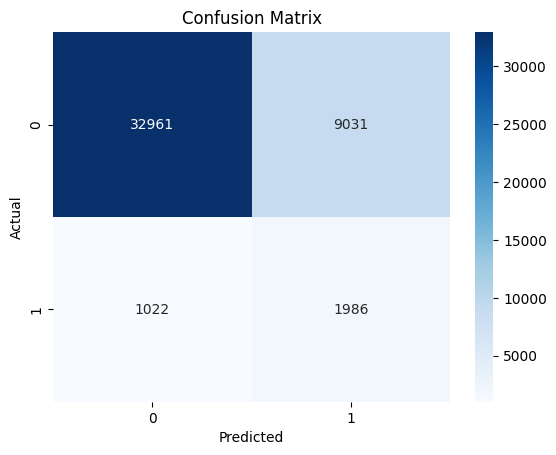

In [9]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [10]:
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC: {roc_auc:.3f}")

ROC AUC: 0.800


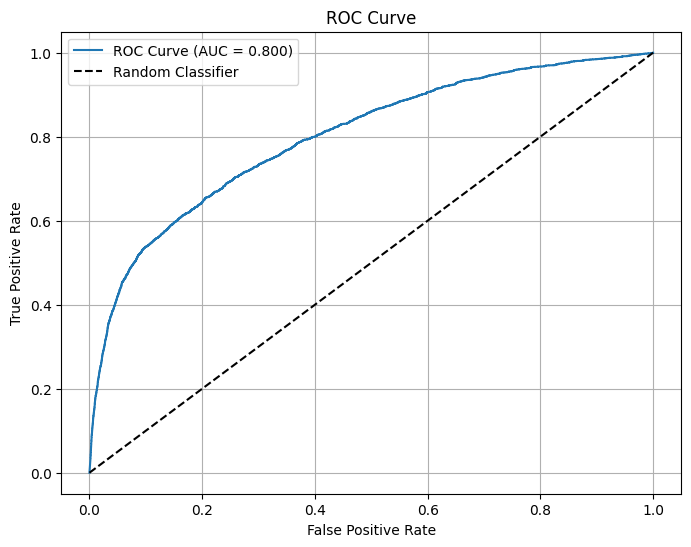

In [11]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

### 🧾 Project Summary

The goal of this project was to build a predictive model to assess whether a customer is likely to experience a serious delinquency (90+ days late) within the next two years (`SeriousDlqin2yrs`), based on demographic and financial information.

#### 🔍 Steps of the analysis:
1. **Data Exploration:** Missing values were identified in the `MonthlyIncome` and `NumberOfDependents` columns and filled using the median.
2. **Visualization:** The distributions of key features such as `age`, `DebtRatio`, and `MonthlyIncome` were analyzed in relation to the target variable. Distinct patterns were observed between delinquent and non-delinquent customers.
3. **Data Preparation:** The dataset was split into training and test sets, and features were standardized using `StandardScaler`.
4. **Modeling:** Logistic Regression was used as the baseline classification model.
5. **Model Evaluation:**
   - **Accuracy:** ~78%  
   - **Precision for class 1:** 0.18  
   - **Recall for class 1:** 0.66  
   - **ROC AUC Score:** 0.707

#### 📊 Insights:
- The model performs well in identifying customers **without delinquencies** (class 0), but struggles with correctly classifying those **with delinquencies** (class 1), due to class imbalance (~93% vs 7%).
- Applying `class_weight='balanced'` improved the **recall** for the minority class at the cost of precision.
- Features like `DebtRatio`, `MonthlyIncome`, and `NumberOfTimes90DaysLate` showed strong predictive power.